# Machine Learning Demonstrations

In this notebook, we showcase how to use kdb+/q paired with embedPy to carry out machine learning tasks. Below we show how to train and test a decision tree classifier to identify benign/malignant samples from the Wisconsin Breast Cancer dataset.

<div class="alert alert-danger">
To run the below notebook, ensure that dependencies specified in <b>requirements.txt</b> have been correctly installed.
</div>

## EmbedPy

EmbedPy allows the kdb+/q interpreter to manipulate Python objects, call Python functions and load Python libraries. Python and kdb+/q developers can fuse both technologies together, allowing for a seamless application of kdb+/q’s high-speed analytics and Python’s rich ecosystem of libraries such as scikit-learn, Tensorflow, PyTorch and Theano.

## Classification Using Decision Trees

Decision trees are a simple yet effective algorithm used for supervised classification and regression problems.

A decision tree is made up of a collection of simple hierarchical decision rules, classifying datapoints into categories by splitting them based on feature values. The task of fitting a decision tree to data therefore involves finding the sequence of feature splits and the optimal split values.

Decision trees can:
- Manage a mixture of discrete, continuous and categorical inputs.
- Use data with no normalization/preprocessing (including missing data).
- Produce a highly interpretable output, which can be easily explained and visualized.

Further discussion of decision trees can be found in the Wikipedia article [Decision tree](https://en.wikipedia.org/wiki/Decision_tree) or [Sci-Kit Learn documentation](http://scikit-learn.org/stable/modules/tree.html).

## Breast Cancer Data

The [Wisconsin Breast Cancer Dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) is a set of 569 samples of fine needle aspirate (FNA) of breast mass. Each sample contains features describing characteristics of the cell nuclei, along with a classification of the sample as either benign or malignant.

---

### Load data

In the cell below, we load in the utilities library from the kdb+/q [ML-Toolkit](https://github.com/KxSystems/ml), along with graphics functions required for this notebook. We then use embedPy to import relevant python modules and load data from the Wisconsin Breast Cancer dataset.

In [1]:
/ load toolkit and graphics functions
\l ../utils/graphics.q
\l ../utils/util.q
\l ml/ml.q
.ml.loadfile`:util/init.q

In [2]:
/ load in data
data:.p.import[`sklearn.datasets;`:load_breast_cancer][]
feat:data[`:data]`
targ:data[`:target]`
featnm:pylist[<]data`:feature_names

/ inspect data
-1"Shape of feature data is: ",(" x "sv string .ml.shape feat),"\n";
show 5#feat
-1"\nDistribution of target values:\n";
show update pcnt:round[;.01]100*num%sum num from select num:count i by target from([]target:targ);

Shape of feature data is: 569 x 30

17.99 10.38 122.8 1001  0.1184  0.2776  0.3001 0.1471  0.2419 0.07871 1.095  ..
20.57 17.77 132.9 1326  0.08474 0.07864 0.0869 0.07017 0.1812 0.05667 0.5435 ..
19.69 21.25 130   1203  0.1096  0.1599  0.1974 0.1279  0.2069 0.05999 0.7456 ..
11.42 20.38 77.58 386.1 0.1425  0.2839  0.2414 0.1052  0.2597 0.09744 0.4956 ..
20.29 14.34 135.1 1297  0.1003  0.1328  0.198  0.1043  0.1809 0.05883 0.7572 ..

Distribution of target values:

target| num pcnt 
------| ---------
0     | 212 37.26
1     | 357 62.74


The output above shows that classes are quite unbalanced:
- `37%` are malignant (0)
- `63%` are benign (1)

---

### Prepare data
Before we can train a model we need to split the original data into training and testing sets. Below we select 50% to be present in the testing set.

In [3]:
\S 123  / random seed
show count each datadict:.ml.traintestsplit[feat;targ;.5]

xtrain| 284
ytrain| 284
xtest | 285
ytest | 285


---

### Build and train the model

At this stage it is possible to fit the data to a decision tree classifier model, restricting the tree to a maximum depth of 3.

In [4]:
clf:.p.import[`sklearn.tree]`:DecisionTreeClassifier
clf:clf[`max_depth pykw 3]
clf[`:fit][datadict`xtrain;datadict`ytrain];

Using the graph visualization software [Graphviz](https://www.graphviz.org/), we can look at the structure of the resulting decision tree.

In [5]:
gv: .p.import`graphviz
egv:.p.import[`sklearn.tree;`:export_graphviz]
dotdata:egv[clf;`out_file pykw (::);`feature_names pykw featnm]
graph:gv[`:Source]dotdata
display graph

Traceback (most recent call last):
  File "/home/deanna/anaconda3/lib/python3.6/site-packages/graphviz/backend.py", line 153, in run
    proc = subprocess.Popen(cmd, startupinfo=get_startupinfo(), **kwargs)
  File "/home/deanna/anaconda3/lib/python3.6/subprocess.py", line 709, in __init__
    restore_signals, start_new_session)
  File "/home/deanna/anaconda3/lib/python3.6/subprocess.py", line 1344, in _execute_child
    raise child_exception_type(errno_num, err_msg, err_filename)
FileNotFoundError: [Errno 2] No such file or directory: 'dot': 'dot'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/deanna/.local/lib/python3.6/site-packages/IPython/core/formatters.py", line 224, in catch_format_error
    r = method(self, *args, **kwargs)
  File "/home/deanna/.local/lib/python3.6/site-packages/IPython/core/formatters.py", line 345, in __call__
    return method()
  File "/home/deanna/anaconda3/lib/python3.6/site-packages/

The decision tree classifier produces a highly interpretable model which can be visualized and understood even by those with a less technical knowledge.

The algorithm finds the best tree by following a greedy strategy where it looks for the feature (mean concave points) and split value (0.052) that most effectively partitions the data.

This divides the dataset of 284 samples into two subsets of 176 samples and 108 samples:
- Of the 176 samples, 7 (4%) are malignant and 169 (96%) are benign.
- Of the 108 samples, 95 (88%) are malignant and 13 (12%) are benign.

The algorithm continues splitting the dataset at each node, by finding the feature and split value that most effectively partitions the benign from the malignant samples.

---

### Evaluate model

The output of the decision tree is a class assignment.

We take a previously unseen sample and pass it through the decision tree. Following the appropriate branch at each split (based on the feature values of the test point), we eventually end up at a leaf node, at the bottom of the tree. At this point, we assign the test point the class value of the majority of the test examples included in that leaf.

We can therefore evaluate the performance of the decision tree on the held-out test data. 

In [6]:
/ make predictions
yprob:clf[`:predict_proba;<]datadict`xtest
ypred:raze{$[2=count x;1?;]x}each imax each yprob

/ calculate performance metrics
dtloss:.ml.logloss[datadict`ytest;yprob]
dtacc:.ml.accuracy[datadict`ytest;ypred]

-1"Performance of the classifier";
-1"log loss: ",string[dtloss],"\naccuracy: ",string dtacc;

Performance of the classifier
log loss: 1.069679
accuracy: 0.9508772


The decision tree classifier achieves 95% accuracy on the test set, a strong performance from such a simple classifier.

---

### Confusion matrix


With a Confusion Matrix, we can inspect the interaction between:
- True positives
- True negatives
- False positives
- False negatives

0| 100 4  
1| 10  171


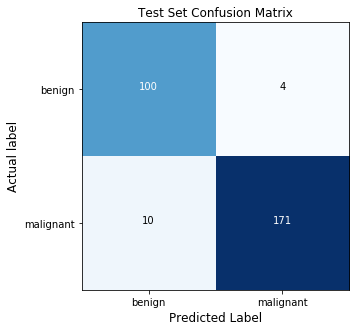

In [7]:
show cnfM:.ml.confmat[datadict`ytest;ypred]
displayCM[value cnfM;`benign`malignant;"Test Set Confusion Matrix";()]

The classifier has:

- True Positive Rate: ```TPR = TP/(TP+FN) = 100/(100+4) = 96%```
- False Positive Rate: ```FPR = FP/(FP+TN) = 10/(10+172) =  5%```

**NB**: We are using *positive* here to denote the malignant case, which actually has the label `0`, rather than `1` in the Wisconsin dataset.

---

### ROC curve
Rather than using a majority vote system, we could use a threshold other than 50% for assigning the points to classes at the leaf node.

- By modifying the threshold in favour of a _malignant_ diagnosis, we would increase the true positive rate, but would also increase the false positive rate.  
- By modifying the threshold in favour of a _benign_ diagnosis, we would decrease the false positive rate, but would also decrease the true positive rate.  

The realtionship between the true positive rate (sensitivity) and the false positive rate, is captured in the Receiver Operating Characteristic (ROC) curve.

Receiver Operating Characteristic (ROC) describes the ability to increase the recall/sensitivity of a model, without decreasing the precision of the model. The ROC value is calulated as the area under the associated ROC curve (plotting true positive rates against false positive rates).

**NB**: `1 - FPR` is called the specificity of the model. We therefore have a trade-off between sensitivity and specificity.

The area under the curve (AUC) is interpreted as the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one.

The optimal classifier would have a false positive rate of 0 and a true positive rate of 1, giving a an AUC curve of 1.

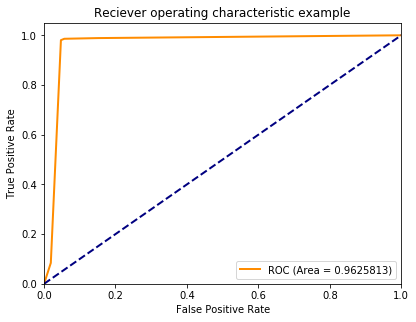

In [8]:
yprob:clf[`:predict_proba;feat]`
displayROC[targ;yprob[;1]]

 With an AUC of 0.96, our classifier is close to optimal.

---